<a href="https://colab.research.google.com/github/bibekebib/Major-project-raw-files/blob/main/first_CNN_%2B_LSTM_model_from_scratch_for_all_images_of_original_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
dataset_path = '/content/drive/MyDrive/dataset'

In [40]:
from glob import glob
import pandas as pd
import cv2 as cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder

In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [42]:
print(device)

cpu


In [43]:
df = pd.read_csv('/content/drive/MyDrive/dataset/origianltraindf_image_path.csv')
testdf = pd.read_csv('/content/drive/MyDrive/dataset/origianltestdf_image_path.csv')

In [44]:
lbe = LabelEncoder()

In [45]:
len(df) / 32

208.0

In [46]:
df.head()

,Unnamed: 0,path,label
0,0,/content/drive/MyDrive/OriginalFramesTrain/tad...,tadasana
1,1,/content/drive/MyDrive/OriginalFramesTrain/tad...,tadasana
2,2,/content/drive/MyDrive/OriginalFramesTrain/tad...,tadasana
3,3,/content/drive/MyDrive/OriginalFramesTrain/tad...,tadasana
4,4,/content/drive/MyDrive/OriginalFramesTrain/tad...,tadasana


In [47]:

df.label = lbe.fit_transform(df.label)
testdf.label = lbe.fit_transform(testdf.label)

In [48]:
df.head()['path'][0]

'/content/drive/MyDrive/OriginalFramesTrain/tadasana/tadasana-Piyush_Tad/ tadasana-Piyush_Tad frame0.jpg'

In [49]:
# df = df.sample(frac=1)

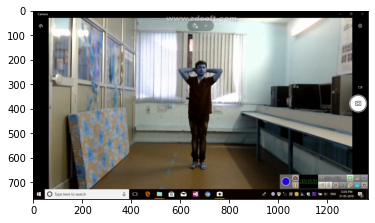

In [50]:
plt.imshow(cv2.imread('/content/drive/MyDrive/OriginalFramesTrain/tadasana/tadasana-Piyush_Tad/ tadasana-Piyush_Tad frame0.jpg'))

In [51]:
class CustomDataset(Dataset):
  def __init__(self, df, transforms=False):  
    self.imgpath = df.path 
    self.label = df.label
    # self.transforms = torchvision.transforms.Compose([
    #     torchvision.transforms.ToTensor(),
    #     torchvision.transforms.ToPILImage(),
    #     # torchvision.transforms.ToTensor(),
    #     # torchvision.transforms.functional.crop(100,100, 324,324)
    # ])
    self.transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize(224)
        # torchvision.transforms.functional.crop(100,100, 324,324)
    ])

  def __len__(self):
    return len(self.imgpath)
  
  def __getitem__(self, ix):
    f = self.imgpath[ix]
    target = (self.label[ix])
    im = cv2.imread(f)
    im = cv2.resize(im, (224,224))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    im = self.transforms(im)
    return torch.tensor(im).to(device).float(), torch.tensor(target).long().to(device)
 


In [52]:
data = CustomDataset(df)

In [53]:
im, label = data[600]

<ipython-input-51-188c1c094215>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im).to(device).float(), torch.tensor(target).long().to(device)


In [54]:
print(im.shape)

torch.Size([1, 224, 224])


tensor(4)
torch.Size([1, 224, 224])


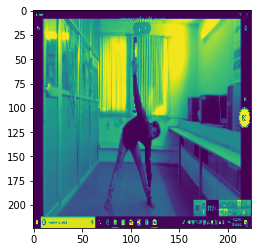

In [55]:
plt.imshow(im.reshape(224,224).detach().cpu())
print(label)
print(im.shape)

In [56]:
import torch.nn as nn

def conv_layer(ni, no, kernel_size, stride=1):
  return nn.Sequential(
      nn.Conv2d(ni, no, kernel_size, stride),
      nn.ReLU(),
      nn.BatchNorm2d(no),
      nn.MaxPool2d(2)
  )

In [57]:
# def get_model():
#   # model = nn.Sequential(
#   #     conv_layer(1,16,3),
#   #     conv_layer(16,64, 3),
#   #     conv_layer(64, 256, 2),
#   #     conv_layer(256, 512,2),
#   #     conv_layer(512,512,2),
#   #     nn.LSTM(input_size=512*5*5, hidden_size=256),
#   #     nn.Linear(512,1000),
#   #     nn.ReLU(),
#   #     nn.Linear(1000, 192),
#   #     nn.ReLU(),
#   #     nn.Linear(192, 3),
#   #     nn.Softmax()
#   # ).to(device)
#   loss_fn = nn.CrossEntropyLoss()
#   optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#   return loss_fn, optimizer

In [58]:
import torch.nn.functional as F
import torch
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = conv_layer(1,16,3)
        self.conv2 = conv_layer(16,64, 3)
        self.conv3 = conv_layer(64, 256, 2)
        self.conv4 = conv_layer(256, 512,2)
        self.conv5 = conv_layer(512,512,2)
        
    def forward(self, i):
        # print(i.shape[1], i.shape[2], i.shape[3])
        x = i.view(-1, i.shape[1], i.shape[2], i.shape[3])
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = nn.AvgPool2d(4)(x)
        x = x.view(i.shape[0], 4, -1)
        # print(i.shape[1])
        return x
    
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(128, 100)
        self.fc = nn.Linear(100*4, 6)
        # self.softmax = nn.Softmax()
        
    def forward(self, x):
        # print(x.shape)
        x, _ = self.lstm(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return (x)   
    

class NewModel(nn.Module):
  def __init__(self, CNN, LSTM):
    super(NewModel, self).__init__()
    self.cnn = CNN
    self.lstm = LSTM

  def forward(self, x):
    head1 = self.cnn(x)
    head2 = self.lstm(head1)
    x = head2
    return x

x = torch.rand((8, 1, 224, 224))
net_cnn = CNN()
net_lstm = LSTM()
model = NewModel(net_cnn, net_lstm)
# features = net_cnn(x)
# out = net_lstm(features)
# print(nn.Softmax(out))
# model = net_lstm(features)
# print(x.shape)
# print(features.shape)
print(model(x))



tensor([[-0.0016,  0.0449, -0.0987,  0.0487,  0.0046,  0.0117],
        [-0.0418,  0.0723, -0.1293,  0.0499,  0.0143,  0.0281],
        [-0.0384,  0.0507, -0.0963,  0.1248, -0.0016, -0.0182],
        [-0.0666,  0.0587, -0.1224,  0.0923,  0.0367,  0.0167],
        [-0.0580,  0.0625, -0.1370,  0.1412,  0.0508,  0.0283],
        [-0.0560,  0.0355, -0.1248,  0.1000,  0.0043,  0.0304],
        [-0.0308,  0.0409, -0.0894,  0.1198,  0.0681,  0.0348],
        [-0.0549,  0.1150, -0.0939,  0.1359,  0.0357,  0.0438]],
       grad_fn=<AddmmBackward0>)


In [59]:
def get_model():
  model = NewModel(net_cnn, net_lstm).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  return model,loss_fn, optimizer

In [60]:
# def calculateHWOUT(H_in, W_IN, padding, kernel_size, stride, max_pool_num):
#     H_out = (((H_in + 2*padding - kernel_size) / stride ) +1) / max_pool_num
#     W_out = (((W_IN + 2*padding - kernel_size) / stride ) +1) / max_pool_num
#     return (int(H_out), int(W_out))

In [61]:
# calculateHWOUT(H_in=12, W_IN=12, padding=0, kernel_size=2, stride=1, max_pool_num=2)

In [62]:
model, loss_fn, optimizer = get_model()
# from torchsummary import summary
# summary(model,( 1, 224, 224), 4)

In [63]:
model

NewModel(
  (cnn): CNN(
    (conv1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv2d(64, 256, kernel_size=(2, 2), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1))
      (1): ReLU()
      (2

In [64]:
def get_data():
  train = CustomDataset(df)
  trn_dl = DataLoader(train, batch_size=8,shuffle=False, drop_last=True)
  test = CustomDataset(testdf)
  test_dl = DataLoader(test, batch_size=8, shuffle=False, drop_last=True)
  return trn_dl, test_dl

In [65]:
def train_batch(x, y, model, loss_fn, opt):
  # cnn = model[0]
  # lstm = model[1]
  # model = lstm(cnn())
  # print(x.insert(1, 4))
  prediction = model(x)
  # prediction = torch.max(prediction.data, 1)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()

In [66]:
@torch.no_grad()
def accuracy(x, y, model):
  # cnn = model[0]
  # lstm = model[1]
  # model = lstm(cnn())
  model.eval()
  pred = model(x)
  _, is_correct = torch.max(pred.data,1)
  acc_all = (is_correct==y).detach().cpu().numpy()
  return acc_all

In [67]:
@torch.no_grad()
def val_loss_trn(x, y, model, loss_fn):
  prediction = model(x)
  val_loss = loss_fn(prediction, y)
  return val_loss.item()

In [68]:
trn_ldr, test_ldr = get_data()
# model, loss_fn, optimizer = get_model()

In [69]:
model, loss_fn, optimizer

(NewModel(
   (cnn): CNN(
     (conv1): Sequential(
       (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
       (1): ReLU()
       (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     )
     (conv2): Sequential(
       (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
       (1): ReLU()
       (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     )
     (conv3): Sequential(
       (0): Conv2d(64, 256, kernel_size=(2, 2), stride=(1, 1))
       (1): ReLU()
       (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     )
     (conv4): Sequential(
       (0): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1))
    

In [70]:
# train_losses, train_accuracies = [], []
# val_losses, val_accuracies = [], []
# for epoch in range(5):
    
#     print(epoch)
#     train_epoch_losses, train_epoch_accuracies = [], []
#     val_epoch_accuracies = []
#     for ix, batch in enumerate(iter(trn_dl)):
#         #print(ix)
#         x, y = batch
#         x = x.reshape(32,1, 224,224)
  
#         batch_loss = train_batch(x, y, model, optimizer, loss_fn)
#         train_epoch_losses.append(batch_loss)        
#     train_epoch_loss = np.array(train_epoch_losses).mean()

#     for ix, batch in enumerate(iter(trn_dl)):
#         x, y = batch
#         x = x.reshape(32, 1, 224, 224)
#         is_correct = accuracy(x, y, model)
#         train_epoch_accuracies.extend(is_correct)
#     train_epoch_accuracy = np.mean(train_epoch_accuracies)



#     train_losses.append(train_epoch_loss)
#     train_accuracies.append(train_epoch_accuracy)
#     #val_losses.append(validation_loss)


In [ ]:
train_loss = []
train_accuracies= []
val_loss = [] 
val_accuracies = []

for i in range(10):
  print(f'Epoch: _________*****{i}*****_______')
  train_epoch_losses, train_epoch_accuracies = [], []
  val_epoch_accuracies, val_epoch_losses = [], []



  for ix, batch in (enumerate(iter(trn_ldr))):
      x, y = batch
      train_epoch_losses.append(train_batch(x, y, model, loss_fn, optimizer))
  train_epoch_loss = np.array(train_epoch_losses).mean()
  print(f'Epoch: _________*****{i} Training Loss : {train_epoch_loss} *****_______')



  for ix, batch in (enumerate(iter(trn_ldr))):
    x, y = batch
    train_epoch_accuracies.append(sum(accuracy(x, y, model)) / len(y))
  train_epoch_accuracy = np.array(train_epoch_accuracies).mean()
  print(f'Epoch: _________*****{i} Training Accuracy: {train_epoch_accuracy} *****_______')


  for ix, batch in (enumerate(iter(test_ldr))):
    x, y = batch
    val_epoch_losses.append(val_loss_trn(x, y, model, loss_fn))
  val_epoch_loss = np.array(val_epoch_losses).mean()
  print(f'Epoch: _________*****{i} Validation Loss : {val_epoch_loss} *****_______')

  for ix, batch in (enumerate(iter(test_ldr))):
    x, y = batch
    val_epoch_accuracies.append(sum(accuracy(x, y, model)) / len(y))
  print(f'Epoch: _________*****{i} Validation Accuracy. {val_epoch_accuracy} *****_______')
  val_epoch_accuracy = np.array(val_epoch_accuracies).mean()
  print('\n')

  train_loss.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_accuracies.append(val_epoch_accuracy)
  val_loss.append(val_epoch_loss)

Epoch: _________*****0*****_______


<ipython-input-51-188c1c094215>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im).to(device).float(), torch.tensor(target).long().to(device)


Epoch: _________*****0 Training Loss : 1.4423157929021937 *****_______
Epoch: _________*****0 Training Accuracy: 0.2107872596153846 *****_______


In [ ]:
epochs = np.arange(10) + 1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(epochs, train_accuracies , label='Training accuracy')
plt.plot(epochs, train_loss, label='Train Loss')
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))

plt.xlabel('epochs')

plt.legend()
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.grid('off')
plt.show()